# Three Bays Mangrove dNDVI Analysis, Artibonite, Haiti

In [2]:
import os
import gc
import json
import glob
import tarfile
import pyproj
import math

import numpy as np
import xarray as xr
import rasterio as rs
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt

from natsort import natsorted
from datetime import datetime
from matplotlib import colors

Getting and sorting .tar file paths from Bulk Download Landsat Ph.D Data directory

In [3]:
#data_dir = 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1/*.tar'
data_dir = 'F:/PhD Data/Landsat 2010-2022/*.tar'
tarpaths = []
# Suffixes and Prefixes to clean to easily sort by observation date 
sfs = ['_02_T1.tar','_02_T2.tar', '_02_T1_B1.TIF', '_02_T1_B2.TIF', '_02_T1_B3.TIF', '_02_T1_B4.TIF', '_02_T1_B5.TIF', '_02_T1_MTL.json',
        '_02_T2_B1.TIF', '_02_T2_B2.TIF', '_02_T2_B3.TIF', '_02_T2_B4.TIF', '_02_T2_B5.TIF', '_02_T2_MTL.json',
        '_02_T1_SR_B1.TIF', '_02_T1_SR_B2.TIF', '_02_T1_SR_B3.TIF', '_02_T1_SR_B4.TIF', '_02_T1_SR_B5.TIF', '_02_T1_MTL.json',
        '_02_T2_SR_B1.TIF', '_02_T2_SR_B2.TIF', '_02_T2_SR_B3.TIF', '_02_T2_SR_B4.TIF', '_02_T2_SR_B5.TIF', '_02_T2_MTL.json']
pfs = ['F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1GT_009047_', 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_', 
        'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009046_', 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LO08_L1GT_009047_',
        'F:/PhD Data/Landsat 2010-2022\LC08_L2SP_009046_', 'F:/PhD Data/Landsat 2010-2022\LC08_L2SP_009047_',
        'F:/PhD Data/Landsat 2010-2022\LE07_L2SP_009047_',
        'extracted/2013/LC08_L1GT_009047_', 'extracted/2013/LC08_L1TP_009047_', 
        'extracted/2013/LC08_L1TP_009046_', 'extracted/2013/LC08_L1GT_009047_',
        'extracted/2013/LC08_L2SP_009046_', 'extracted/2013/LC08_L2SP_009047_',
        'extracted/2013/LE07_L2SP_009047_','extracted/2021/LC08_L1GT_009047_', 'extracted/2021/LC08_L1TP_009047_', 
        'extracted/2021/LC08_L1TP_009046_', 'extracted/2021/LC08_L1GT_009047_',
        'extracted/2021/LC08_L2SP_009046_', 'extracted/2021/LC08_L2SP_009047_',
        'extracted/2021/LE07_L2SP_009047_']
# Parse through .tar files in folder
for filepath in glob.iglob(data_dir):
    tarpaths.append(filepath)

# Returns observation date
def rm_prefsuf(x):
    for sf in sfs:
        x = x.removesuffix(sf)
    for pf in pfs:
        x = x.removeprefix(pf)
    return (x)[:-9]

# Sort list of paths by observation dates
tarpaths = natsorted(tarpaths, key=lambda x: datetime.strptime(rm_prefsuf(x), '%Y%m%d'))

## dNDVI Analysis - Average 2013 vs Average 2021

Extent of mangrove forest for cropping

In [4]:
bay_p = '../shapefiles/horn.shp'
bay_boundary = gpd.read_file(bay_p)

P = pyproj.Proj(proj='utm', zone=31, ellps='WGS84', preserve_units=True)
min_coords = P(bay_boundary.bounds.minx[0],bay_boundary.bounds.miny[0], inverse=True)
max_coords = P(bay_boundary.bounds.maxx[0],bay_boundary.bounds.maxy[0], inverse=True)

In [5]:
extent = bay_boundary.total_bounds
print(min_coords)
max_coords

(5.224340176929641, 19.320439060588388)


(5.270394844526299, 19.383393928823853)

Retrieving .tar bands from early and recent observations

In [6]:
rs.Env(VRT_SHARED_SOURCE = 0)

paths2013 = []
paths2021 = []
# Only grab bands 1 through 5
wanted = ['B4.TIF', 'B5.TIF', 'MTL.json']
wanted_LS7 = ['B3.TIF', 'B4.TIF', 'MTL.json']

for tar in tarpaths:
    yr = (datetime.strptime(rm_prefsuf(tar), '%Y%m%d')).year
    if yr == 2010:
        paths2013.append(tar)
    if yr == 2021:
        paths2021.append(tar)

### [2010 Data] Extract band files for temporary use (only Bands 1 to 5) and calculate NDVI

In [7]:
# First observation
ndvi13 = []
j = 0
for path in paths2013:
    current_date = datetime.strptime(rm_prefsuf(path), '%Y%m%d')
    archive1 = tarfile.open(path, 'r')
    archive1.getmembers()
    band_files_13 = []
    for file in archive1.getmembers():
        #print(file.name + ': ' + str(file.name.endswith(tuple(wanted))))
        if file.name.endswith(tuple(wanted_LS7)):
            band_files_13.append(file)
            file.uname
    band_files_13 = natsorted(band_files_13, key=lambda x: x.name)

    # Bands extraction
    for f in band_files_13:
        archive1.extract(f, path='extracted/2013/')
        # Stack bands in list and open metadata
    bands = []
    directory = 'extracted/2013/'
        # Looping over all GeoTIFF files
    i = 0
    for entry in os.scandir(directory):
        entry_date = datetime.strptime(rm_prefsuf(entry.path), '%Y%m%d')
        # Tries to open .TIF files of the current obs date, if that fails, know we reached the .json metadata file and get that instead
        if entry_date == current_date:
            try:
                fp = entry.path
                # Open and crop bands to mangrove extent
                bands.append(rxr.open_rasterio(fp).rio.clip(bay_boundary.geometry, from_disk=True).squeeze())
                bands[i]["Band"] = i+1
                i += 1
            except Exception as e:
                i = 0
                metadata = json.load(open(entry.path))
    # Calculate NDVI for single observation date and stack
    nir = bands[1].astype(float).squeeze()
    red = bands[0].astype(float).squeeze()
    ndvi= (nir - red) / (nir + red)
    msavi2 = (2*nir + 1 - np.sqrt((2*nir + 1)**2 - 8*(nir-red)))/2
    ndvi13.append(msavi2)
    ndvi13[j]['Observ'] = j+1

Stack NDVI values and take average for the year

In [8]:
ds13 = xr.concat(ndvi13, dim='Observ')
ds13 = ds13.mean(dim='Observ')

Plotting NDVI from 2013

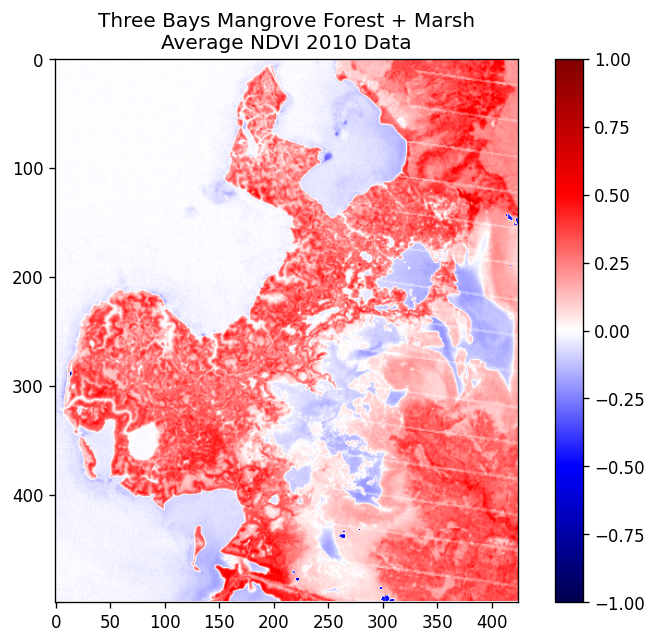

In [9]:
fig = plt.figure(figsize=(8, 6), dpi=120)
nd = plt.imshow(ds13, vmin=-1, vmax=1)

plt.title("Three Bays Mangrove Forest + Marsh\nAverage NDVI 2010 Data")
plt.set_cmap('seismic')
plt.colorbar(nd)

plt.show()

Cleaning up variables and deleting .tiff files for 2013

In [10]:
#del ds13, bands13
gc.collect()

for i, entry in enumerate(os.scandir(directory)):
    try:
        ds13[i].close()
        gc.collect()
        os.remove(entry.path)
    except Exception as e:
        try:
            gc.collect()
            os.remove(entry.path)
        except:
            print('cant delete ' + entry.path + '\nfile still in use')


### [2021 Data] Extract band files for temporary use (only Bands 1 to 5) and calculate NDVI

In [11]:
# First observation
ndvi21 = []
j = 0
for path in paths2021:
    current_date = datetime.strptime(rm_prefsuf(path), '%Y%m%d')
    archive2 = tarfile.open(path, 'r')
    archive2.getmembers()
    band_files_21 = []
    for file in archive2.getmembers():
        #print(file.name + ': ' + str(file.name.endswith(tuple(wanted))))
        if file.name.endswith(tuple(wanted)):
            band_files_21.append(file)
            file.uname
    band_files_21 = natsorted(band_files_21, key=lambda x: x.name)

    # Bands extraction
    for f in band_files_21:
        archive2.extract(f, path='extracted/2021/')
        # Stack bands in list and open metadata
    bands = []
    directory = 'extracted/2021/'
        # Looping over all GeoTIFF files
    i = 0
    for entry in os.scandir(directory):
        entry_date = datetime.strptime(rm_prefsuf(entry.path), '%Y%m%d')
        # Tries to open .TIF files of the current obs date, if that fails, know we reached the .json metadata file and get that instead
        if entry_date == current_date:
            try:
                fp = entry.path
                # Open and crop bands to mangrove extent
                bands.append(rxr.open_rasterio(fp).rio.clip(bay_boundary.geometry, from_disk=True).squeeze())
                bands[i]["Band"] = i+1
                i += 1
            except Exception as e:
                i = 0
                metadata = json.load(open(entry.path))
    # Calculate NDVI for single observation date and stack
    nir = bands[1].astype(float)
    red = bands[0].astype(float)
    ndvi= (nir - red) / (nir + red)
    msavi2 = (2*nir + 1 - np.sqrt((2*nir + 1)**2 - 8*(nir-red)))/2
    ndvi21.append(msavi2)
    ndvi21[j]['Observ'] = j+1

Stack NDVI values and take average

In [12]:
ds21 = xr.concat(ndvi21, dim='Observ')
ds21 = ds21.mean(dim='Observ')

Plotting data from 2021

In [13]:
ds21.values

array([[ 0.00960754,  0.00981933,  0.01003369, ...,  0.2491057 ,
         0.23883683,  0.25443001],
       [ 0.00922449,  0.01023277,  0.01030528, ...,  0.25463617,
         0.23388809,  0.24668359],
       [ 0.00900443,  0.00946991,  0.0100638 , ...,  0.25788539,
         0.23935141,  0.2457836 ],
       ...,
       [-0.00439922, -0.00358948, -0.00481059, ...,  0.35092824,
         0.37522354,  0.40926617],
       [-0.0047581 , -0.00429991, -0.00479634, ...,  0.27258866,
         0.27952649,  0.33170996],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [14]:
ds21[ds21.values < 0] = np.nan

IndexError: Unlabeled multi-dimensional array cannot be used for indexing: y

In [ ]:
plt.figure(figsize=(8, 6), dpi=120)
nd = plt.imshow(ds21, vmin=-1, vmax=0)
plt.title("Three Bays Mangrove Forest + Marsh\nAverage NDVI 2021 Data")
plt.set_cmap('seismic')
plt.colorbar(nd)
plt.show()

NameError: name 'plt' is not defined

Cleaning up varibles and deleting .tiff files for 2021

In [ ]:
#del ds13, bands13
gc.collect()

for i, entry in enumerate(os.scandir(directory)):
    try:
        ds21[i].close()
        gc.collect()
        os.remove(entry.path)
    except Exception as e:
        try:
            gc.collect()
            os.remove(entry.path)
        except:
            print('cant delete ' + entry.path + '\nfile still in use')

### dNDVI Calculation and Plotting

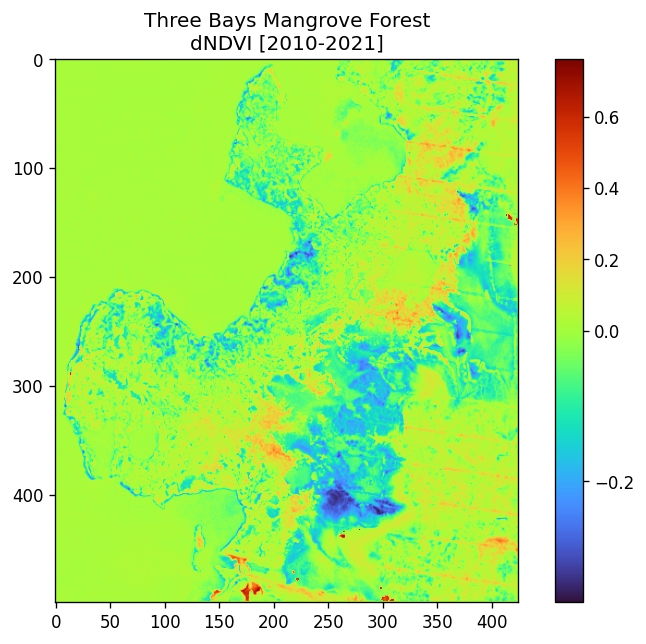

In [15]:
ndvi13 = ds13.fillna(-999)
ndvi21 = ds21.fillna(-999)
dndvi = ndvi21 - ndvi13
dndvi = np.where((ndvi21>-999) & (ndvi13>-999),dndvi,-999)
plt.figure(figsize=(8, 6), dpi=120)

plt.title("Three Bays Mangrove Forest\ndNDVI [2010-2021]")

divnorm = colors.TwoSlopeNorm(vcenter=0)
#colors = ["darkorange", "black", "lawngreen"]
#cmap1 = LinearSegmentedColormap.from_list('viridis', colors)
nd = plt.imshow(dndvi, cmap='seismic', norm=divnorm)
plt.colorbar()
plt.show()